# Replicating opt-SNE

### Preliminaries

In [1]:
import sys 
!{sys.executable} -m pip install flowkit 

In [4]:
%matplotlib inline

# imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import flowkit as fk 
from openTSNE import TSNE
# import FlowCal

In [5]:
file_path = 'data/flow18_annotated.fcs'
# flow_data = FlowCal.io.FCSData(file_path)
flow_data = fk.Sample(file_path)
print("FCS file loaded successfully!")

FCS file loaded successfully!


In [6]:
# Pre-processing data 

sample = fk.Sample('data/flow18_annotated.fcs', sample_id='flow18', channel_labels=('Parameter_1', 'Parameter_10', 'Parameter_11', 'Parameter_12', 'Parameter_13', 'Parameter_14', 'Parameter_15', 'Parameter_16', 'Parameter_17', 'Parameter_18', 'Parameter_19', 'Parameter_2', 'Parameter_20', 'Parameter_21', 'Parameter_22', 'Parameter_23', 'Parameter_24', 'Parameter_3', 'Parameter_4', 'Parameter_5', 'Parameter_6', 'Parameter_7', 'Parameter_8', 'Parameter_9', 'SampleID', 'class'))
df_events = sample.as_dataframe(source="raw")

# only use selected columns 
selected_columns = [
    'Parameter_10', 'Parameter_11', 'Parameter_12', 
    'Parameter_13', 'Parameter_15', 'Parameter_18', 'Parameter_20', 
    'Parameter_21', 'Parameter_23', 'Parameter_8', 'Parameter_9', 'class'
]

df_filtered = df_events[selected_columns]

fraction_used = 1.0 

# sample from dataset 
data_sample = df_filtered.sample(frac=fraction_used).reset_index(drop=True)

# get features and labels 
features = data_sample.drop(columns=['class'])  # All columns except 'class'
labels = data_sample['class']  # Only the 'class' column

In [5]:
print(len(features))

1000021


In [7]:
# KLD Tracker 
from openTSNE import callbacks
# Define a custom callback to record KL divergence
class KLDTracker(callbacks.Callback):
    def __init__(self, record_every=10):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        # Record KL divergence at the specified interval
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

## Section 1: Number of Iterations

In [8]:
# step 1: define affinities 
import openTSNE 
affinites = openTSNE.affinity.PerplexityBasedNN(
    features.to_numpy(),
    perplexity=50, 
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1009.60 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 629.33 seconds


In [9]:
# step 2: define initial embedding 
# init = openTSNE.initialization.pca(features.to_numpy(), random_state=12)
init = openTSNE.initialization.random(n_samples=len(features) ,random_state=12, verbose=True)

In [10]:
# step 3: construct TSNEEmbedding object 
embedding = openTSNE.TSNEEmbedding(
    init, 
    affinites, 
    random_state=12,
    verbose=True
)

#### total iter: 1000, EE stop: 250

In [10]:
## step 4: EE phase 
kld_tracker_EE = KLDTracker(record_every=5)
flow1000_embedding = embedding.optimize(
    n_iter=250, 
    learning_rate=200, 
    exaggeration=12, 
    momentum=0.5, 
    callbacks= kld_tracker_EE, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 226.5161 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 226.2842 sec
Iteration  150, KL divergence 9.7230, 50 iterations in 226.3001 sec
Iteration  200, KL divergence 9.7230, 50 iterations in 226.2208 sec
Iteration  250, KL divergence 9.7230, 50 iterations in 226.1560 sec
   --> Time elapsed: 1131.48 seconds


In [11]:
# Convert to DataFrame 
# embedding_df = pd.DataFrame(EE250_embedding, columns=['x', 'y'])
# embedding_df['label'] = labels
# Save to CSV
# embedding_df.to_csv('flow18_EE250_new_param.csv', index=False)

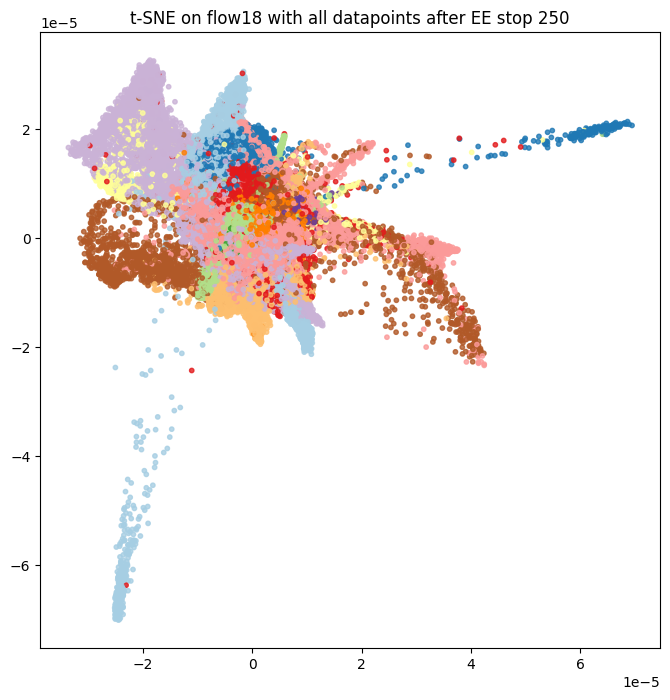

In [12]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints after EE stop 250")
plt.show()

In [13]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed = KLDTracker(record_every=5)

flow1000_embedding = flow1000_embedding.optimize(
    n_iter=750, 
    learning_rate=200, 
    momentum=0.8, 
    callbacks=kld_tracker_embed, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 224.9684 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 224.8901 sec
Iteration  150, KL divergence 9.7229, 50 iterations in 224.7879 sec
Iteration  200, KL divergence 9.7066, 50 iterations in 226.2919 sec
Iteration  250, KL divergence 9.1437, 50 iterations in 226.5624 sec
Iteration  300, KL divergence 8.5018, 50 iterations in 226.6683 sec
Iteration  350, KL divergence 8.1519, 50 iterations in 226.8963 sec
Iteration  400, KL divergence 7.9136, 50 iterations in 225.1670 sec
Iteration  450, KL divergence 7.7320, 50 iterations in 225.1276 sec
Iteration  500, KL divergence 7.5838, 50 iterations in 225.2037 sec
Iteration  550, KL divergence 7.4575, 50 iterations in 225.1826 sec
Iteration  600, KL divergence 7.3467, 50 iterations in 225.5004 sec
Iteration  650, KL divergence 7.2476, 50 iterations in 225.4729 sec
Iteration  700, KL divergence 7.15

In [14]:
# Convert to DataFrame 
# embedding_df = pd.DataFrame(final_embedding_short, columns=['x', 'y'])
# embedding_df['label'] = labels
# Save to CSV
# embedding_df.to_csv('flow18_EE250_1000iter_new_param.csv', index=False)

missing so far: KLD plot (TODO)

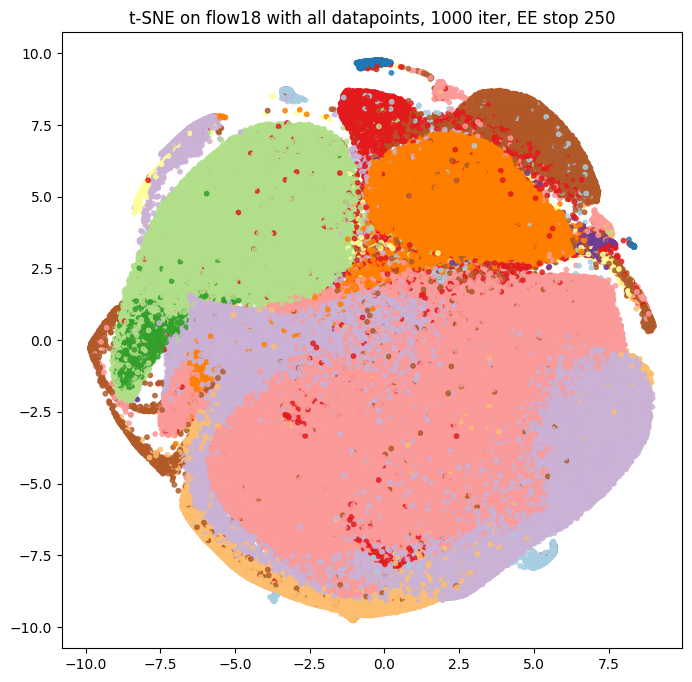

In [15]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow1000_embedding[:, 0], 
    flow1000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints, 1000 iter, EE stop 250")
plt.show()

In [20]:
adjusted_divergences = [(iterations + 250, errors) for (iterations, errors) in kld_tracker_embed.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 1000 iter, 250 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

NameError: name 'kld_tracker_embed' is not defined

#### total iter: 3000, EE stop: 750

In [11]:
## step 4: EE phase 
kld_tracker_EE2 = KLDTracker(record_every=5)
flow3000_embedding = embedding.optimize(
    n_iter=750, 
    learning_rate=200, 
    momentum=0.5, 
    exaggeration=12, 
    callbacks= kld_tracker_EE2, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=12.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 9.7230, 50 iterations in 462.7930 sec
Iteration  100, KL divergence 9.7230, 50 iterations in 454.1538 sec
Iteration  150, KL divergence 9.7230, 50 iterations in 451.0535 sec
Iteration  200, KL divergence 9.7230, 50 iterations in 478.0578 sec
Iteration  250, KL divergence 9.7230, 50 iterations in 409.7056 sec
Iteration  300, KL divergence 9.7230, 50 iterations in 404.5995 sec
Iteration  350, KL divergence 9.7230, 50 iterations in 405.1964 sec
Iteration  400, KL divergence 9.7230, 50 iterations in 409.6627 sec
Iteration  450, KL divergence 9.7230, 50 iterations in 518.7554 sec
Iteration  500, KL divergence 9.7230, 50 iterations in 412.4650 sec
Iteration  550, KL divergence 9.7228, 50 iterations in 410.5286 sec
Iteration  600, KL divergence 9.7187, 50 iterations in 406.2687 sec
Iteration  650, KL divergence 9.6435, 50 iterations in 401.6388 sec
Iteration  700, KL divergence 9.2

In [12]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(flow3000_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('tSNE_results/flow3000_afterEE.csv', index=False)

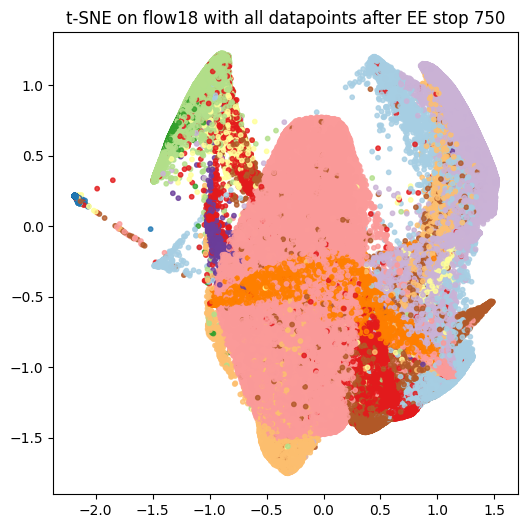

In [13]:
plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    flow3000_embedding[:, 0], 
    flow3000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints after EE stop 750")
plt.show()

In [14]:
# step 5: embedding phase of t-SNE 
kld_tracker_embed2 = KLDTracker(record_every=5)

flow3000_embedding = flow3000_embedding.optimize(
    n_iter=2250, 
    learning_rate=200, 
    momentum=0.8, 
    exaggeration=1, 
    callbacks=kld_tracker_embed2, 
    callbacks_every_iters=5, 
    verbose=True
)

===> Running optimization with exaggeration=1.00, lr=200.00 for 2250 iterations...
Iteration   50, KL divergence 8.1745, 50 iterations in 536.3328 sec
Iteration  100, KL divergence 7.7860, 50 iterations in 420.0055 sec
Iteration  150, KL divergence 7.5337, 50 iterations in 419.6075 sec
Iteration  200, KL divergence 7.3501, 50 iterations in 417.6718 sec
Iteration  250, KL divergence 7.2058, 50 iterations in 417.9968 sec
Iteration  300, KL divergence 7.0871, 50 iterations in 419.7875 sec
Iteration  350, KL divergence 6.9863, 50 iterations in 408.6739 sec
Iteration  400, KL divergence 6.8985, 50 iterations in 409.2613 sec
Iteration  450, KL divergence 6.8208, 50 iterations in 403.4817 sec
Iteration  500, KL divergence 6.7510, 50 iterations in 423.4566 sec
Iteration  550, KL divergence 6.6876, 50 iterations in 406.7641 sec
Iteration  600, KL divergence 6.6294, 50 iterations in 404.7633 sec
Iteration  650, KL divergence 6.5756, 50 iterations in 409.8122 sec
Iteration  700, KL divergence 6.5

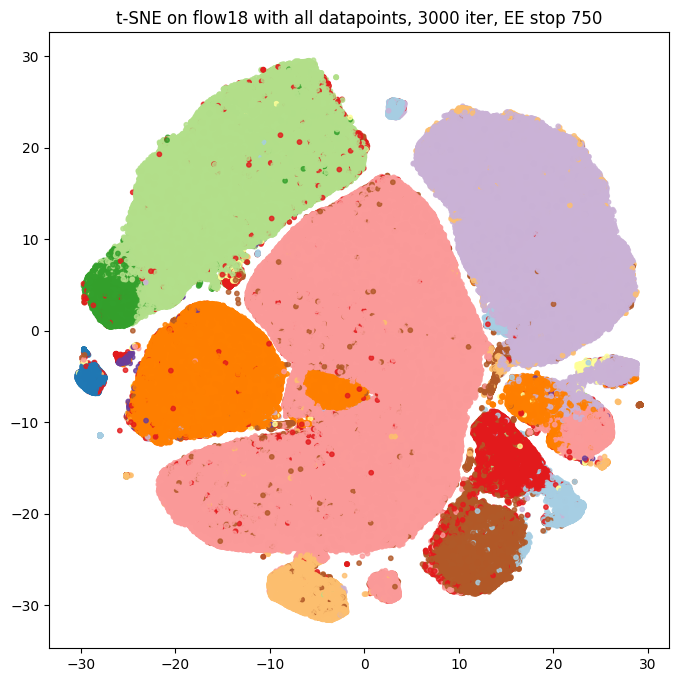

In [15]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    flow3000_embedding[:, 0], 
    flow3000_embedding[:, 1], 
    c=labels, 
    cmap=plt.colormaps.get_cmap('Paired'), 
    s=10, 
    alpha=0.8
)
plt.title("t-SNE on flow18 with all datapoints, 3000 iter, EE stop 750")
plt.show()

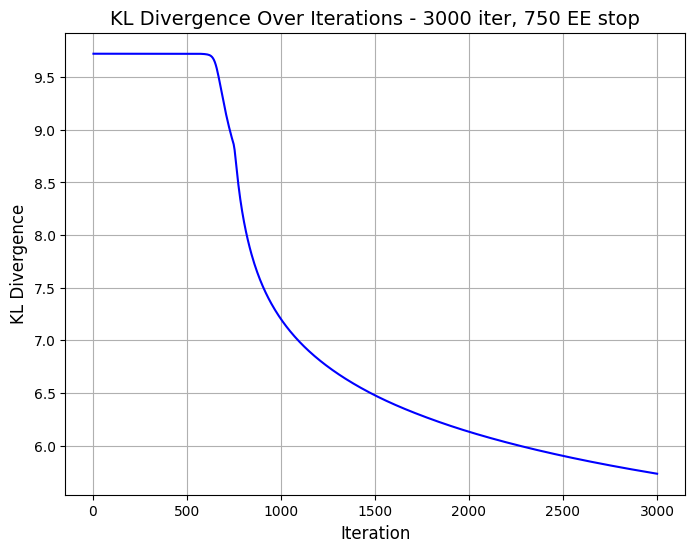

In [19]:
adjusted_divergences = [(iterations + 750, errors) for (iterations, errors) in kld_tracker_embed2.kl_divergences]
iterations, errors = zip(*(kld_tracker_EE2.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, linestyle='-', color='b')
plt.title("KL Divergence Over Iterations - 3000 iter, 750 EE stop", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

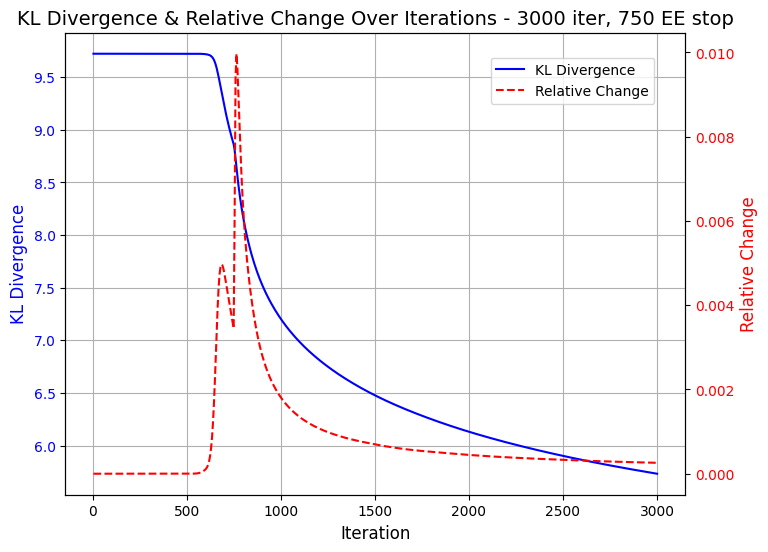

In [28]:
# Calculate relative change in KL Divergence
errors = np.array(errors)
relative_change = np.zeros_like(errors)
relative_change[1:] = (errors[:-1] - errors[1:]) / errors[:-1]  # Relative change calculation

# Plot KL Divergence and Relative Change
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot KL Divergence
ax1.plot(iterations, errors, linestyle='-', color='b', label='KL Divergence')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("KL Divergence", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Secondary y-axis for Relative Change
ax2 = ax1.twinx()
ax2.plot(iterations, relative_change, linestyle='--', color='r', label='Relative Change')
ax2.set_ylabel("Relative Change", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("KL Divergence & Relative Change Over Iterations - 3000 iter, 750 EE stop", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(0.87, 0.85))

plt.show()


In [17]:
# Convert to DataFrame 
embedding_df = pd.DataFrame(flow3000_embedding, columns=['x', 'y'])
embedding_df['label'] = labels
# Save to CSV
embedding_df.to_csv('tSNE_results/flow18_EE750_3000iter_new_param.csv', index=False)

In [ ]:
# List of embeddings
all_embeddings = [EE250_embedding, final_embedding_short, EE750_embedding, final_embedding_long]

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Title for the entire figure
fig.suptitle("Impact of iteration length on t-SNE embeddings", fontsize=16, y=0.92)

# Subtitles for each subplot
subtitles = ["250 EE", "250 EE, 1000 iter", "750 EE", "750 EE, 3000 iter"]

# Plot each embedding in the corresponding subplot
for ax, embedding, subtitle in zip(axes.flat, all_embeddings, subtitles):
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                          c=labels, cmap=plt.colormaps.get_cmap('Paired'), s=10, alpha=0.8)
    ax.set_xticks([])  # Hide x ticks
    ax.set_yticks([])  # Hide y ticks
    ax.set_title(subtitle, fontsize=12)  # Subtitle for each subplot

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the main title
plt.show()
